In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
from textblob import TextBlob
import numpy as np
import operator
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

import math
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **MAJORITY CLASSIFIER**

Majority class classifier, which identifies the class used most frequently in the training data and predicts every data point in the evaluation data to be that class.


In [74]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[1]

            X.append(text)
            Y.append(label)

    return X, Y

In [75]:
def majority_class(trainY, evalY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in evalY:
        if label == majority_class:
            correct+=1
    return majority_class, correct/len(evalY)

In [76]:
trainingFile = "drive/MyDrive/train.txt"
devFile = "drive/MyDrive/dev.txt"
testFile = "drive/MyDrive/test.txt"

trainX, trainY=load_data(trainingFile)
devX, devY=load_data(devFile)
testX, testY=load_data(testFile)

mc, mc_devAcc=majority_class(trainY, devY)
_, mc_testAcc=majority_class(trainY, testY)

print("Majority class: %s, dev accuracy: %.3f, test accuracy: %.3f" % (mc, mc_devAcc, mc_testAcc))

Majority class: Strongly Worded, dev accuracy: 0.440, test accuracy: 0.380


## **ORDINAL REGRESSION**

[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiclass classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [77]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])

    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[1]

            X.append(text)

            index = ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)

    return X, Y, orig_Y

In [78]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.testX_raw = testX
        self.devX_raw = devX

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model

    def test(self):
        cor = tot = 0

        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]

        preds=np.array(preds)
        for data_point in range(len(preds[0])):
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

  # FOR DEBUGGING / EVALUATION...
    def example_test(self, dataset="test", use_override=True, use_rule_only=False):
      if dataset == "test":
        dataX = self.testX_raw
        goldY = self.orig_testY
      elif dataset == "dev":
        dataX = self.devX_raw
        goldY = self.orig_devY
      else:
        raise ValueError("dataset must be 'test' or 'dev'")

      cor = tot = 0
      for i, sentence in enumerate(dataX):
        if use_rule_only:
          predicted_label = self.predict_by_score(sentence)
        else:
          predicted_label, _ = self.predict_one(sentence, override=use_override)

        if predicted_label == goldY[i]:
            cor += 1
        tot += 1

      return cor / tot

    def predict_one(self, sentence, override=False):
      feats = self.feature_method(sentence)

      # Vectorize for model prediction
      F = len(self.feature_vocab)
      X = sparse.dok_matrix((1, F))
      for feat in feats:
          if feat in self.feature_vocab:
              X[0, self.feature_vocab[feat]] = feats[feat]

      # Get ordinal class probabilities
      preds = [lr.predict_proba(X)[0][1] for lr in self.log_regs]
      ordinal_probs = np.zeros(len(self.ordinal_values))
      ordinal_probs[0] = 1 - preds[0]
      for i in range(1, len(self.ordinal_values) - 1):
          ordinal_probs[i] = preds[i - 1] - preds[i]
      ordinal_probs[-1] = preds[-1]

      model_margin = np.sort(ordinal_probs)[-1] - np.sort(ordinal_probs)[-2]
      model_pred_idx = np.argmax(ordinal_probs)
      model_label = self.ordinal_values[model_pred_idx]

      if override:
         # Rule-based score
          scores = self.score_by_class(feats)
          rule_label = max(scores, key=scores.get)
          rule_conf = scores[rule_label]
          # Thresholds per class
          thresholds = {
              "Apathetic": 1.5,
              "Moderate": 2.0,
              "Strongly Worded": 2.5,
              "Extreme": 1.5
          }

          # Decide final label
          override_applied = False
          if (override and rule_label != model_label
              and rule_conf > thresholds[rule_label]
              and model_margin < 0.4):
              return rule_label, ordinal_probs
      return model_label, ordinal_probs

    def print_feature_importance(self, top_n=15, high_only = False):
      inv_vocab = {idx: feat for feat, idx in self.feature_vocab.items()}
      for i, model in enumerate(self.log_regs):
          print(f"\n--- Feature importances for {self.ordinal_values[i+1]} and above ---")
          coef = model.coef_[0]
          sorted_idx = coef.argsort()

          if not high_only:
            print("\nLowest-weighted features:")
            for idx in sorted_idx[:top_n]:
                print(f"{inv_vocab[idx]:<30} {coef[idx]:.3f}")

          print("\nHighest-weighted features:")
          for idx in reversed(sorted_idx[-top_n:]):
              print(f"{inv_vocab[idx]:<30} {coef[idx]:.3f}")

    def score_by_class(self, feats):
      scores = {
          "Apathetic": 0.0,
          "Moderate": 0.0,
          "Strongly Worded": 0.0,
          "Extreme": 0.0
      }

      subj = feats.get("sentiment_subjectivity", 0)
      hate = feats.get("has_hate_speech", 0)
      violence = feats.get("has_violent_terms", 0)
      ideological = feats.get("has_ideological_violence", 0)
      imperative = feats.get("imperative_present", 0)
      modal = feats.get("modal_present", 0)
      pron_we = feats.get("pronoun_we_group", 0)
      pron_they = feats.get("pronoun_they_group", 0)
      apathy = feats.get("apathetic_signal", 0)
      military = feats.get("has_military_terms", 0)
      terrorism = feats.get("terrorism_term", 0)
      group_blaming = feats.get("group_blaming_language", 0)
      extreme_pattern = feats.get("extreme_pattern_match", 0)

      # --- Rhetorical count from phrase indicators ---
      rhetorical_keywords = [
          "we must", "fight", "rigged", "enemy", "take back", "stand up",
          "we will never", "reclaim", "stop the steal"
      ]
      rhet_count = sum([feats.get(f"rhet_{phrase.replace(' ', '_')}", 0) for phrase in rhetorical_keywords])

      # Apathetic
      scores["Apathetic"] += 2.0 * apathy
      scores["Apathetic"] += max(0, 0.5 - subj)  # low subjectivity = apathetic
      scores["Apathetic"] -= 1.5 * imperative + modal + rhet_count
      scores["Apathetic"] -= 2.0 * violence + 2.0 * hate

      # Moderate
      scores["Moderate"] += 1.0 * pron_we + 0.5 * modal
      scores["Moderate"] += max(0.5 - subj, 0.2)
      scores["Moderate"] += 1.0 if violence == 0 and hate == 0 else 0
      scores["Moderate"] -= 1.0 * violence + 1.0 * hate

      # Strongly Worded
      scores["Strongly Worded"] += 1.5 * rhet_count + subj + imperative
      scores["Strongly Worded"] += 0.7 * pron_they + 0.7 * group_blaming
      scores["Strongly Worded"] += modal + 0.5 * hate

      # Extreme
      scores["Extreme"] += 2.5 * violence + 2.5 * hate + 2.0 * ideological
      scores["Extreme"] += 1.0 * pron_they + 1.2 * military + 1.0 * terrorism
      scores["Extreme"] += 1.5 * imperative + 1.5 * extreme_pattern
      scores["Extreme"] += 0.5 * group_blaming  # group blame often escalates

      return scores

    def predict_by_score(self, sentence):
      # Get features
      feats = self.feature_method(sentence)

      # Get heuristic scores
      scores = self.score_by_class(feats)

      # Pick label with highest score
      predicted_label = max(scores, key=scores.get)

      return predicted_label

    def get_predictions(self):
      dataX = self.testX_raw
      goldY = self.orig_testY
      X_sparse = self.testX

      y_true = []
      y_pred = []

      preds = [lr.predict_proba(X_sparse)[:, 1] for lr in self.log_regs]
      preds = np.array(preds)

      for i in range(len(preds[0])):
        ordinal_probs = np.zeros(len(self.ordinal_values))
        ordinal_probs[0] = 1 - preds[0][i]
        for j in range(1, len(self.ordinal_values) - 1):
            ordinal_probs[j] = preds[j - 1][i] - preds[j][i]
        ordinal_probs[-1] = preds[-1][i]

        pred_idx = np.argmax(ordinal_probs)
        gold_idx = self.ordinal_values.index(goldY[i])

        y_pred.append(self.ordinal_values[pred_idx])
        y_true.append(self.ordinal_values[gold_idx])

      return y_true, y_pred

In [79]:
# attempting to create a formula to predict with... not as good as improved_bow_featurized.
def tone_score_featurized(text):
    feats = Counter()
    words = nltk.word_tokenize(text)
    lowered = [w.lower() for w in words]
    lowered_text = " ".join(lowered)

    # --- Sentiment (from TextBlob) ---
    blob = TextBlob(text)
    feats["sentiment_subjectivity"] = blob.sentiment.subjectivity

    # --- Hate speech / insult terms ---
    hate_terms = {"traitor", "invader", "scum", "vermin", "filth", "rapist", "illegals",
                  "thugs", "cruel", "loser", "dumb", "hate", "evil", "criminals", "animals",
                  "terrorists", "kill", "murder", "slaughter", "extremist", "extremists"}
    hate_count = sum(1 for word in lowered if word in hate_terms)
    feats["has_hate_speech"] = int(hate_count > 0)

    # --- Violent Terms ---
    violent_terms = {"murder", "slaughter", "execute", "exterminate", "annihilate",
                     "eradicate", "kill", "stab", "shoot", "lynch", "hunt", "abuse", "hang"}
    violent_count = sum(1 for word in lowered if word in violent_terms)
    feats["has_violent_terms"] = int(violent_count > 0)

    # --- Ideological Violence ---
    feats["has_ideological_violence"] = int("beliefs" in lowered and any(w in lowered for w in violent_terms))

    # --- Custom rhetorical keyword features ---
    rhetorical_phrases = {
        "we must", "fight", "rigged", "enemy", "take back", "stand up",
        "we will never", "reclaim", "stop the steal"
    }
    feats["rhetorical_count"] = sum(1 for phrase in rhetorical_phrases if phrase in lowered_text)

    # --- Pronoun skew ---
    pronoun_counts = Counter(word for word in lowered if word in {"we", "our", "us", "they", "them", "their", "theirs"})
    feats["pronoun_skew"] = pronoun_counts["they"] - pronoun_counts["we"]

    # --- Apathetic tone ---
    apathetic_signals = ["not a big deal", "doesn’t matter", "don't care", "move on", "isn't important",
                         "do not care", "could be worse", "no point", "does not matter", "is not important"]
    feats["apathetic_signal"] = sum(1 for phrase in apathetic_signals if phrase in lowered_text)

    # --- Modals ---
    modals = ["must", "shall", "should", "need to", "ought to", "have to"]
    feats["modal_present"] = sum(1 for modal in modals if modal in lowered_text)

    # --- Imperatives ---
    imperatives = ["stand up", "take back", "fight", "join", "resist", "reject"]
    feats["imperative_present"] = sum(1 for imp in imperatives if imp in lowered_text)

    # --- Militaristic vocabulary ---
    militaristic = {"troops", "attack", "defend", "enemy", "war", "mission", "strike", "military",
                    "terrorist", "missile", "bomb", "gun", "police", "officer", "army", "soldier"}
    feats["military_vocab_count"] = sum(1 for word in lowered if word in militaristic)
    feats["has_military_terms"] = int(feats["military_vocab_count"] > 0)

    # --- Group Blame ---
    blame_patterns = ["they caused", "they ruined", "their fault", "they are the reason", "they must pay", "they made", "they did"]
    feats["group_blaming_language"] = sum(1 for pattern in blame_patterns if pattern in lowered_text)

    # --- Extreme Language ---
    extreme_patterns = ["must kill", "kill them", "murder them", "they are animals",
                        "we will exterminate", "no right to live", "need to be wiped out", "they must suffer"]
    feats["extreme_pattern_match"] = sum(1 for pattern in extreme_patterns if pattern in lowered_text)

    # --- Terrorism terms ---
    terrorism_terms = {"isis", "qaeda", "terror", "terrorists"}
    feats["terrorism_term"] = int(any(word in terrorism_terms for word in lowered))

    # === Final tone score ===
    tone_score = (
        1.5 * feats["rhetorical_count"] +
        2.0 * feats["has_hate_speech"] +
        2.0 * feats["has_violent_terms"] +
        1.2 * feats["imperative_present"] +
        1.0 * feats["has_ideological_violence"] +
        0.8 * feats["pronoun_skew"] +
        0.7 * feats["modal_present"] +
        0.5 * feats["has_military_terms"] +
        1.0 * feats["sentiment_subjectivity"] +
        0.5 * feats["terrorism_term"] +
        1.2 * feats["group_blaming_language"] +
        1.5 * feats["extreme_pattern_match"] -
        1.5 * feats["apathetic_signal"]
    )

    return {"tone_score": tone_score}


In [80]:
def improved_bow_featurize(text):
    feats = Counter()
    words = nltk.word_tokenize(text)
    lowered = [w.lower() for w in words]

    # --- bag-of-words ---
    stopwords_set = set(stopwords.words("english"))

    for word in lowered:
        if word not in stopwords_set and len(word) > 2 and word.isalpha():
            feats[f"word_{word}"] += 1

    # --- Sentiment features (TextBlob) ---
    blob = TextBlob(text)
    feats["sentiment_polarity"] = blob.sentiment.polarity
    feats["sentiment_subjectivity"] = blob.sentiment.subjectivity

    # --- Hate speech / insult terms ---
    hate_terms = {"traitor", "invader", "scum", "vermin", "filth", "rapist", "illegals", "hell", "devils"
                  "thugs", "cruel", "loser", "dumb", "hate", "evil", "criminals", "animals",
                  "terrorists", "kill", "murder", "slaughter", "extremist", "extremists"}
    feats["hate_speech_vocab_count"] = sum(1 for word in lowered if word in hate_terms)

    # --- Violent Terms ---
    violent_terms = {"murder", "slaughter", "execute", "exterminate", "annihilate", "force"
                     "eradicate", "kill", "stab", "shoot", "lynch", "hunt", "abuse", "hang"}
    feats["violent_action_count"] = sum(1 for word in lowered if word in violent_terms)

    # --- Ideological Violence ---
    if "beliefs" in lowered and any(w in lowered for w in violent_terms):
      feats["ideological_violence_flag"] = 1

    # --- Custom rhetorical keyword features ---
    rhetorical_phrases = {
        "we must": "rhet_we_must",
        "fight": "rhet_fight",
        "rigged": "rhet_rigged",
        "enemy": "rhet_enemy",
        "take back": "rhet_take_back",
        "stand up": "rhet_stand_up",
        "we will never": "rhet_never_concede",
        "reclaim": "rhet_reclaim",
        "stop the steal": "rhet_stop_the_steal"
    }

    lowered_text = " ".join(lowered)
    for phrase, feat_name in rhetorical_phrases.items():
        if phrase in lowered_text:
            feats[feat_name] += 1

    # --- Pronoun distribution ---
    first_person_plural = {"we", "our", "us"}
    second_person = {"you", "your", "yours"}
    third_person_plural = {"they", "them", "their", "theirs"}

    for word in lowered:
        if word in first_person_plural:
            feats["pronoun_we_group"] += 1
        if word in second_person:
            feats["pronoun_you"] += 1
        if word in third_person_plural:
            feats["pronoun_they_group"] += 1

    # --- Apathetic tone ---
    apathetic_signals = ["not a big deal", "doesn’t matter", "don't care", "move on", "isn't important", "will not"
                         "do not care", "could be worse", "no point", "does not matter", "is not important"]
    for phrase in apathetic_signals:
        if phrase in text.lower():
            feats["apathetic_signal"] += 1

    # --- Modals ---
    modals = ["must", "shall", "should", "need to", "ought to", "have to"]
    for modal in modals:
        if modal in text.lower():
            feats["modal_present"] += 1

    # --- Commands ---
    imperatives = ["stand up", "take back", "fight", "join", "resist", "reject", "act"]
    for imp in imperatives:
        if imp in text.lower():
            feats["imperative_present"] += 1

    # --- Militaristic vocabulary ---
    militaristic = {"troops", "attack", "defend", "enemy", "war", "mission", "strike", "military",
                    "terrorist", "missile", "bomb", "gun", "police", "officer", "army", "soldier"}
    feats["military_vocab_count"] = sum(1 for word in lowered if word in militaristic)

    # --- Group Blame ---
    blame_patterns = ["they caused", "they ruined", "their fault", "they are the reason", "they must pay", "they made", "they did"]
    for pattern in blame_patterns:
        if pattern in lowered_text:
            feats["group_blaming_language"] += 1

    # -- Political Distrust --
    politic_bad = ["crooked", "corrupt", "rigged", "thieves", "woke", "radical", "racist", "bigotted", "manipulating"]
    for pattern in blame_patterns:
        if pattern in lowered_text:
            feats["political_distruct_language"] += 1

    # --- Extreme Language ---
    extreme_patterns = ["must kill", "kill them", "murder them", "they are animals", "radical left", "woke",
                        "we will exterminate", "no right to live", "need to be wiped out", "they must suffer"]
    for pattern in extreme_patterns:
        if pattern in lowered_text:
            feats["extreme_pattern_match"] += 1

    terrorism_terms = {"isis", "qaeda", "terror", "terrorists"}

    feats["terrorism_term"] = int(any(word in terrorism_terms for word in lowered))
    feats["has_hate_speech"] = int(feats["hate_speech_vocab_count"] > 0)
    feats["has_violent_terms"] = int(feats["violent_action_count"] > 0)
    feats["has_military_terms"] = int(feats["military_vocab_count"] > 0)
    feats["has_ideological_violence"] = feats.get("ideological_violence_flag", 0)

    # # --- Minimiziers ---
    # minimizers = ["maybe", "probably", "not a big deal", "could be worse"]
    # for word in minimizers:
    #     if word in text.lower():
    #         feats["minimizer_present"] += 1

    # # --- Fact Based ---
    # fact_based = {"data", "policy", "evidence", "report", "analysis", "studies", "economic", "legal", "proven"}
    # feats["fact_based_count"] = sum(1 for word in lowered if word in fact_based)
    # feats["uses_fact_based_terms"] = int(feats["fact_based_count"] > 0)

    # # --- Hopeful Terms ---
    # hopeful_terms = {"hope", "dream", "together", "unite", "justice", "peace", "love", "freedom"}
    # feats["positive_persuasion"] = sum(1 for word in lowered if word in hopeful_terms)

    # racial_terms = {"white", "black", "blacks", "muslims", "negro", "jews", "latinos", "viet", "arab"}
    # oppression_terms = {"segregation", "racism", "racist", "slavery"}

    # feats["racial_identity_term"] = int(any(word in racial_terms for word in lowered))
    # feats["oppression_term"] = int(any(word in oppression_terms for word in lowered))

    return feats

In [81]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [94]:
def example_classifications(classifier):
  sentence = "not a big deal"
  predicted_label, probs = classifier.predict_one(sentence)
  print(f"Predicted tone: {predicted_label}")
  print(f"Probabilities: {probs}")

  sentence = "We the people."
  predicted_label, probs = classifier.predict_one(sentence)
  print(f"Predicted tone: {predicted_label}")
  print(f"Probabilities: {probs}")

  sentence = "This is an important problem, and they are the ones to blame"
  predicted_label, probs = classifier.predict_one(sentence)
  print(f"Predicted tone: {predicted_label}")
  print(f"Probabilities: {probs}")

  sentence = "The radical left knows exactly what they're doing. They're ruthless and it's time that somebody did something about it."
  predicted_label, probs = classifier.predict_one(sentence)

  print(f"Predicted tone: {predicted_label}")
  print(f"Probabilities: {probs}")

def test_all_models(classifier):

  rule_only_dev = classifier.example_test(dataset="dev", use_rule_only=True)
  print(f"Rule-only dev accuracy: {rule_only_dev:.3f}")

  rule_only_test = classifier.example_test(dataset="test", use_rule_only=True)
  print(f"Rule-only test accuracy: {rule_only_test:.3f}")

  baseline_dev = classifier.example_test(dataset="dev", use_override=False)
  print(f"Model-only dev accuracy: {baseline_dev:.3f}")

  baseline_test = classifier.example_test(dataset="test", use_override=False)
  print(f"Model-only test accuracy: {baseline_test:.3f}")

  dev_acc = classifier.example_test(dataset="dev", use_override=True)
  print(f"Hybrid dev accuracy: {dev_acc:.3f}")

  test_acc = classifier.example_test(dataset="test", use_override=True)
  print(f"Hybrid test accuracy: {test_acc:.3f}")

In [103]:
def run(trainingFile, devFile, testFile, ordinal_values):

    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, improved_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model:\n%.3f, 95%% Confidence Intervals: [%.3f %.3f]\n" % (accuracy, lower, upper))

    # example_classifications(simple_classifier)
    print("Testing other variations of the model and reporting their accuracies:\n")
    test_all_models(simple_classifier)

    return simple_classifier

In [104]:
trainingFile = "drive/MyDrive/train.txt"
devFile = "drive/MyDrive/dev.txt"
testFile = "drive/MyDrive/test.txt"

ordinal_values=["Apathetic", "Moderate", "Strongly Worded", "Extreme"]

classifier = run(trainingFile, devFile, testFile, ordinal_values)

Test accuracy for best dev model:
0.700, 95% Confidence Intervals: [0.610 0.790]

Testing other variations of the model and reporting their accuracies:

Rule-only dev accuracy: 0.410
Rule-only test accuracy: 0.560
Model-only dev accuracy: 0.640
Model-only test accuracy: 0.700
Hybrid dev accuracy: 0.560
Hybrid test accuracy: 0.710


## **Analysis**

### What labels are often mistaken for each other -- Confusion Matrix:



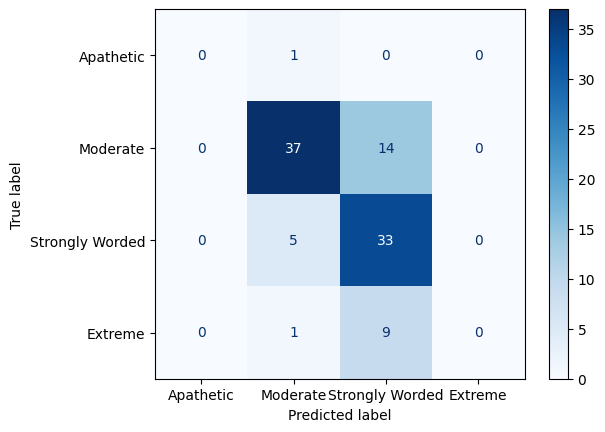

In [85]:
def plot_confusion_matrix(classifier):
  y_true, y_pred = classifier.get_predictions()
  cm = confusion_matrix(y_true, y_pred, labels=classifier.ordinal_values)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.ordinal_values)
  disp.plot(cmap="Blues")

plot_confusion_matrix(classifier)

0 Apathetic Predicted, 0 Extreme Predicted:
  - Reason for this is probably that not as much data for these categories to train our model on, leads to it over predicting the more prevalent labels (Moderate and Strongly Worded)
  - Might need to find more features that help differentiate between strongly worded and extreme since most extremes were predicted to be Strongly Worded.

The confusion matrix revealed important patterns in the model’s performance. Notably, there were zero Apathetic and zero Extreme predictions across the entire test set. This suggests that the model is heavily biased toward predicting the more frequent categories (Moderate and Strongly Worded) which clearly reflects the distribution of the training data we provided. With fewer Apathetic and Extreme examples available during training, the model lacked sufficient examples to learn strong, distinguishing decision boundaries for these rarer classes. As a result, ambiguous or borderline examples were systematically pushed toward the more common categories. Additionally, many true Extreme examples were predicted as Strongly Worded. This indicates that while the model can recognize intensity, it struggles to separate violent rhetoric (Extreme) from strong but non-violent rhetoric (Strongly Worded).

### What features are learned to most define the classes?

In [86]:
classifier.print_feature_importance(high_only = True, top_n = 10)


--- Feature importances for Moderate and above ---

Highest-weighted features:
pronoun_they_group             0.093
military_vocab_count           0.056
pronoun_we_group               0.050
word_people                    0.049
has_military_terms             0.037
pronoun_you                    0.034
modal_present                  0.033
imperative_present             0.031
word_world                     0.029
word_war                       0.027

--- Feature importances for Strongly Worded and above ---

Highest-weighted features:
word_white                     1.156
word_negro                     0.971
word_longer                    0.847
word_time                      0.763
word_years                     0.740
word_segregation               0.725
word_racist                    0.679
word_racism                    0.675
word_struggle                  0.653
word_government                0.642

--- Feature importances for Extreme and above ---

Highest-weighted features:
violent_action

The majority of the features that the model learned with a high frequency were expected; nevertheless, there are some features that were learned that came as a surprise to us. For Moderate text, the model learned that the presence of collective pronouns like "they" and "we" (pronoun_they_group, pronoun_we_group) was highly predictive. However, it was somewhat surprising that military vocabulary (military_vocab_count, has_military_terms) also had a positive weight toward Moderate. We originally anticipated military language would be more indicative of Strongly Worded or Extreme rhetoric, but the model suggests that references to military or national security are common even in moderate political discourse without necessarily conveying aggression.

For Strongly Worded text, the model heavily emphasized racial and historical terms such as "white", "negro", "segregation", "racism", and "struggle". This was largely expected, given that many strongly worded political speeches historically reference racial injustice and societal divides with assertive language. However, the magnitude of importance placed on racial identifiers was larger than we had initially anticipated, suggesting that the model strongly associates Strongly Worded tone with discussions of racial events, even when explicit violent rhetoric is absent.

For Extreme text, the model correctly prioritized features related to violence and terror, such as violent_action_count, terrorism_term, and words like "act", "hang", "terrorists", and "immediately". This matches our expectations as we predcited that references to violence, calls for immediate radical action, and the use of terrorism-related language would be highly indicative of Extreme tone. Interestingly, the model assigned notable weight to the word "throughout" as well, potentially capturing how extreme rhetoric sometimes uses sweeping generalizations across populations or geographic spaces.

### What kind of systematic mistakes does your model make?

In [87]:
def print_misclassified_examples(classifier):
    preds = [lr.predict_proba(classifier.testX)[:, 1] for lr in classifier.log_regs]
    preds = np.array(preds)
    confusion_pairs = Counter()

    for i in range(len(preds[0])):
        ordinal_probs = np.zeros(len(classifier.ordinal_values))
        ordinal_probs[0] = 1 - preds[0][i]
        for j in range(1, len(classifier.ordinal_values) - 1):
            ordinal_probs[j] = preds[j - 1][i] - preds[j][i]
        ordinal_probs[-1] = preds[-1][i]

        predicted_idx = np.argmax(ordinal_probs)
        gold_idx = classifier.ordinal_values.index(classifier.orig_testY[i])

        if predicted_idx != gold_idx:
            gold_label = classifier.ordinal_values[gold_idx]
            predicted_label = classifier.ordinal_values[predicted_idx]
            confusion_pairs[(gold_label, predicted_label)] += 1

    print("Most common confusion pairs (gold → predicted):")
    for (gold, pred), count in confusion_pairs.most_common():
        print(f"{gold:20s} → {pred:20s}: {count} times")

print_misclassified_examples(classifier)

Most common confusion pairs (gold → predicted):
Moderate             → Strongly Worded     : 14 times
Extreme              → Strongly Worded     : 9 times
Strongly Worded      → Moderate            : 5 times
Apathetic            → Moderate            : 1 times
Extreme              → Moderate            : 1 times


We observed that the model tended to systematically confuse examples labeled as “Moderate” or “Extreme” with “Strongly Worded”, showing it struggles to distinguish between different intensities of emotional language. For instance, strongly emotional texts such as “And it is a war of unparalleled brutality…” and “Historically, revolutions are bloody, oh yes they are..” were both gold-labeled as “Extreme” but incorrectly predicted as “Strongly Worded”, while more moderate texts like “And going forward, it is essential that Pakistan continue to join us in the fight against al Qaeda..” and “Your struggles are our struggles” were also misclassified the same way. Even intense language, like "We fight like Hell and if you don't fight like Hell, you're not going to have a country anymore," was marked as “Strongly Worded” instead of “Extreme.” Occasionally, it also confused apathetic statements, such as "We must begin by acknowledging the hard truth: We will not eradicate violent conflict in our lifetimes," with “Moderate.” Overall, these mistakes suggest the model has a hard time detecting fine-grained differences in intensity and often leans toward predicting middle-ground labels like “Strongly Worded” when faced with both moderate and extreme input.

### Is one label extremely prevalent? How could this impact the model you developed? Is your dataset a good candidate for strategies like oversampling or changing class weights?

In [88]:
y_true, y_pred = classifier.get_predictions()

predicted_counts = Counter(y_pred)

print("Number of times each label was predicted:")
for label in classifier.ordinal_values:
    print(f"{label:20s}: {predicted_counts[label]} times")

Number of times each label was predicted:
Apathetic           : 0 times
Moderate            : 44 times
Strongly Worded     : 56 times
Extreme             : 0 times


Clear that apathetic and extreme are either not as prevalent due to being on the extremes in terms of rhetoric or because our way of classifying what qualifies as either is not clear or might be too specific.
- This could be a problem with Strongly Worded and Moderate being too vague as some excerpts which would normally be classified on either extreme don't fall under either extreme or apathetic due to bad class weighting.
- Could also be a problem with how most of our examples fall under Strongly Worded or Moderate, not enough examples of Apathetic and Extreme in our training data.

The moderate and strongly worded labels are extremely prevalent in our dataset. This leads the model to heavily predict either Moderate or Strongly Worded. Some runs of the model even predict Apathetic or Extreme 0 times. We determined that our dataset did not have enough Apathetic or Extreme quotes for our model to accurately predict them. Another thing that could have contributed to this is that political speeches are often in a Moderate or Strongly Worded tone. Politicians most likely don’t want to come across like they don’t care about an issue, or that their stance is too extreme, so it would make sense for most political speeches to lie in the middle.

### What improvements can be made to this model?

Our model ultimately ended up getting a 70% accuracy on the test set, altough this is quite high, considering our baseline was 38%, there is definitely still some room for improvement. Including more speeches from a wider range of political eras within the training set would provide a wider range of political perspective which would furhter assist the model with accurately predicting tone regardless of time-period. Furthermore, including speeches from different political affiliations, especially those on either extreme of the political spectrum, would allow for better collection and representation of both apathetic and extreme labels which would in turn help the model better determine those labels. To improve on the analysis itself we could add more features and implement Cross-Validation and analyzing VIFs for tuning hyper-parameters.